# Trabajo Computacional 2

In [6]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data
def ldata2(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append([col[0],col[1]])
    return data
def ldata3(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col[1])
    return data

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy
red_proteinas=ldata("tc02Data/yeast_AP-MS.txt")
red_binarias=ldata("tc02Data/yeast_Y2H.txt")
red_literatura=ldata("tc02Data/yeast_LIT.txt")
Esencialidad=ldata3("tc02Data/Essential_ORFs_paperHe.txt")
red_litreguly=ldata2("tc02Data/yeast_LIT_Reguly.txt")



In [9]:
G = nx.Graph()#directed
G.add_edges_from(red_proteinas)
G1 = nx.Graph()#directed
G1.add_edges_from(red_binarias)
G2 = nx.Graph()#directed
G2.add_edges_from(red_literatura)
G3 = nx.Graph()#directed
G3.add_edges_from(red_litreguly)

In [4]:
def K(H):
    k=sum(H.degree(k) for k in H)/H.number_of_nodes()
    salida=[k]
    return salida

In [5]:
data = pd.DataFrame({"Red":["Proteinas","Binarias","Literatura", "Literatura Reg."],
                     "Número de Nodos":[G.number_of_nodes(),G1.number_of_nodes(),G2.number_of_nodes(), G3.number_of_nodes()],
                     "Número de Enlaces":[G.number_of_edges(),G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges()],
                 "Grado medio ":[K(G),K(G1),K(G2),K(G3)],
                 "Clustering promedio":[nx.average_clustering(G),nx.average_clustering(G1),nx.average_clustering(G2),nx.average_clustering(G3)] })
cols= ['Red', 'Número de Nodos', 'Número de Enlaces', 'Grado medio ','Clustering promedio']

data[cols]


,Red,Número de Nodos,Número de Enlaces,Grado medio,Clustering promedio
0,Proteinas,1622,9070,[11.183723797780518],0.554636
1,Binarias,2018,2930,[2.9038652130822595],0.046194
2,Literatura,1536,2925,[3.80859375],0.292492
3,Literatura Reg.,3309,11859,[7.167724388032639],0.260976


In [6]:
def overlap(J,K):
    a=0
    for j in nx.edges(J):
        for i in nx.edges(K):
            if i==j or i[0]==j[1] and i[1]==j[0]:
                a+=1 
                
    return a/nx.number_of_edges(J), a/nx.number_of_edges(K) 

In [7]:
Over1=overlap(G,G1)
Over2=overlap(G,G2)
Over3=overlap(G,G3)
Over4=overlap(G1,G2)
Over5=overlap(G1,G3)
Over6=overlap(G2,G3)


In [8]:
data = pd.DataFrame({".":["Proteinas",Over1[0],Over2[0], Over3[0]],
                     "..":[Over1[1],"Binarias",Over4[0],Over5[0]],
                     "...":[Over2[1],Over4[1],"Literatura",Over6[0]],
                 "....":[Over3[1],Over5[1],Over6[1],"Literatura Reg."]})
cols= ['.', '..', '...', '....']

data[cols]


,.,..,...,....
0,Proteinas,0.0887372,0.443761,0.212497
1,0.0286659,Binarias,0.0888889,0.0403913
2,0.143109,0.0887372,Literatura,0.241167
3,0.277839,0.163481,0.977778,Literatura Reg.


In [6]:
def NodosEsencialesGrado(J,K):
    NE=[]
    k=[]
    for i in nx.nodes(J):
        for j in K:
            if i==j:
                NE.append(i)
                k.append(J.degree(i))
    return k, NE    

In [7]:
def Histograma(J,K):  
    F=NodosEsencialesGrado(J,K)
    plt.hist(F[0],bins=max(F[0]))
    plt.title("Histograma")
    return plt.show()

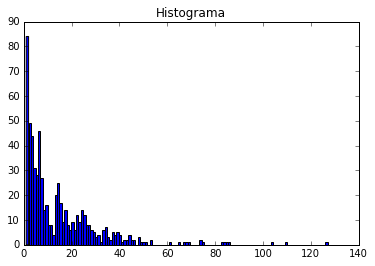

In [8]:
Histograma(G,Esencialidad)

In [9]:
def Zotenko(Grafo,Lista):
    Gcc = sorted(nx.connected_component_subgraphs(Grafo), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    G0 = Gcc[0]
    ###Acá seteamos los esenciales y le damos su grado
    #NE=[]
    k=[]
    for i in nx.nodes(G0):
        for j in Lista:
            if i==j:
                #NE.append(i)
                k.append(G0.degree(i))
    #k_NE=[k,NE]
    
    ###Seteamos todos los nodos y su grado
    #N=[]
    K=[]
    for i in nx.nodes(G0):
        #N.append(i)
        K.append(G0.degree(i))
    #k_N=[K,N]
    
    ###Número de hubbs (normalizado) y k0
    A=[]
    #ko=[]
    B=[]
    for k0 in set(K):
        a=0
        for i in K:
            if i>=k0:
                a+=1
        A.append(a/nx.number_of_nodes(G0))
        #ko.append(k0)
        ###El eje y  
        b=0
        for l in k:
            if l>=k0:
                b+=1
        B.append(b/a)
    
    return A,B

In [10]:
Ñ=Zotenko(G,Esencialidad)
Ñ1=Zotenko(G1,Esencialidad)
Ñ2=Zotenko(G2,Esencialidad)
Ñ3=Zotenko(G3,Esencialidad)

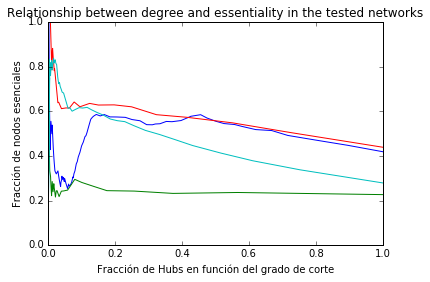

In [11]:
plt.plot(Ñ[0],Ñ[1])
plt.plot(Ñ1[0],Ñ1[1])
plt.plot(Ñ2[0],Ñ2[1])
plt.plot(Ñ3[0],Ñ3[1])
plt.title("Relationship between degree and essentiality in the tested networks")
plt.ylabel("Fracción de nodos esenciales")
plt.xlabel("Fracción de Hubs en función del grado de corte")
plt.show()

In [4]:
def Nnodos (H):    
    Gcc = sorted(nx.connected_component_subgraphs(H), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    G0 = Gcc[0] #componente gigante 
    return G0.number_of_nodes() #función que me devuelve el número de nodos de la componente gigante de un grafo
    
def Sacando_nodos(Grafo,GN,NumeroDeNodo):
    G=Grafo
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
    NnodosComponenteGigante=[]
    NodosQueSaco=[]
    N=0
    for g,n in GN:
        if N<NumeroDeNodo-1:#número de nodos menos 1 

            N+=1
            Gcc[0].remove_node(n)
            NnodosComponenteGigante.append(Nnodos(Gcc[0])) #me devuelve el número de nodos de la componente gigante 
            NodosQueSaco.append(N) #me devuelve el número de nodos que saque hasta el momento (=número de pasos)
                                    #ver de dividirlo por el total de nodos
    return NnodosComponenteGigante, NodosQueSaco

def Shuffle_en_nodo(lista,orden,GradoMaximo):  #función que me devuelve lista de grado-nodo pero que shufflea dentro de los nodos de mismo grado 
    GNordenado_shuflle=[]
    RANGO=[i for i in range(GradoMaximo+1)]
    if orden=="AS":
        for i in RANGO:
            GRADO=[]
            NODO=[]

            for j in lista:
                if j[0]==i:
                    GRADO.append(j[0])
                    NODO.append(j[1])

            random.shuffle(NODO)
            a=0
            for h in GRADO:
                GNordenado_shuflle.append([h,NODO[a]])
                a+=1
    else:
        for i in sorted(RANGO,reverse=True):
            GRADO=[]
            NODO=[]

            for j in lista:
                if j[0]==i:
                    GRADO.append(j[0])
                    NODO.append(j[1])

            random.shuffle(NODO)
            a=0
            for h in GRADO:
                GNordenado_shuflle.append([h,NODO[a]])
                a+=1
        
    return GNordenado_shuflle

In [59]:
def DemoliendoRedes(Grafo,NumeroDeNodos,Centralidad,iteraciones):
    G=copy.deepcopy(Grafo)
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
    NnodosComponenteGigante=[]
    NQS=list(np.arange(1,NumeroDeNodos))
    NodosQueSaco=[]
    for i in NQS:
        NodosQueSaco.append(i/NumeroDeNodos)
    
    N=0
    if Centralidad=="Grado":
        C=nx.degree_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Autovector":
        C=nx.eigenvector_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Subgrafo":
        C=nx.communicability_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="CaminoMasCorto":
        C=nx.betweenness_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Flujo":
        C=nx.current_flow_closeness_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Random":
        NodosCG=[]
        for j in range(iteraciones):
            NN=0
            G_j=copy.deepcopy(Gcc[0])
            Nodos=list(G_j.nodes())
            random.shuffle(Nodos)
            NnodosCGrandom=[]
            for n in Nodos[:NumeroDeNodos-1]:
                if NN<NumeroDeNodos-1:
                    NN+=1
                    G_j.remove_node(n)
                    NnodosCGrandom.append(Nnodos(G_j)/NumeroDeNodos) 
#                    NodosQueSaco.append(NN/NumeroDeNodos) ##revisar. Hay que  ver si es necesario considerarlo o no. Trae problemas así cómo está porque no lo estamos promediando...
            NodosCG.append(NnodosCGrandom) 
        
        for i in range(NumeroDeNodos-1):
            lista=[]
            for k in range(iteraciones):
                lista.append(NodosCG[k][i])
            NnodosComponenteGigante.append(sum(lista)/iteraciones)
        
        
    return NnodosComponenteGigante, NodosQueSaco       

In [10]:
Centralidades=["Grado","Autovector","CaminoMasCorto","Flujo", "Random"]
Grafos=[G,G1,G2,G3]
TamañoComponenteGigante=[Nnodos(G),Nnodos(G1),Nnodos(G2),Nnodos(G3)]

In [67]:
def creartxt(lista1,lista2,NombreArchivo):         ##Lo único que hay que decirle es las dos listas a guardar. Se podrían guardar más, pero hace falta agregar un par de cosas
    with open(NombreArchivo,'w') as f:             ##Nombre de archivo hay que ponerlo entre comillas y punto txt. Es el nombre que queremos que tenga el archivo
        a=0
        for item in lista1:
            f.write("{}\t{}\n".format(item,lista2[a]))
            a+=1

In [15]:
##Todo: cuatro grandes listas (una por cada grafo)
##Todo[i]:cinco listas (una por cada centralidad)
##Todo[i][j]:dos listas (una Tamaño de CG y otra Nodos que saco)

#a=0
#Todo=[]
#for j in Grafos:
#    kaka=[]
#    for i in Centralidades:
#        kaka.append(DemoliendoRedes(j,TamañoComponenteGigante[a],i,100))
#    Todo.append(kaka)
#    a+=1

#creartxt(Todo[0][0][0],Todo[0][0][1],"G_Grado.txt")
#creartxt(Todo[0][1][0],Todo[0][1][1],"G_Autovector.txt")
#creartxt(Todo[0][2][0],Todo[0][2][1],"G_CaminoMasCorto.txt")
#creartxt(Todo[0][3][0],Todo[0][3][1],"G_Flujo.txt")
#creartxt(Todo[0][4][0],Todo[0][3][1],"G_Random.txt")

#creartxt(Todo[1][0][0],Todo[1][0][1],"G1_Grado.txt")
#creartxt(Todo[1][1][0],Todo[1][1][1],"G1_Autovector.txt")
#creartxt(Todo[1][2][0],Todo[1][2][1],"G1_CaminoMasCorto.txt")
#creartxt(Todo[1][3][0],Todo[1][3][1],"G1_Flujo.txt")
#creartxt(Todo[1][4][0],Todo[1][3][1],"G1_Random.txt")

#creartxt(Todo[2][0][0],Todo[2][0][1],"G2_Grado.txt")
#creartxt(Todo[2][1][0],Todo[2][1][1],"G2_Autovector.txt")
#creartxt(Todo[2][2][0],Todo[2][2][1],"G2_CaminoMasCorto.txt")
#creartxt(Todo[2][3][0],Todo[2][3][1],"G2_Flujo.txt")
#creartxt(Todo[2][4][0],Todo[2][3][1],"G2_Random.txt")

#creartxt(Todo[3][0][0],Todo[3][0][1],"G3_Grado.txt")
#creartxt(Todo[3][1][0],Todo[3][1][1],"G3_Autovector.txt")
#creartxt(Todo[3][2][0],Todo[3][2][1],"G3_CaminoMasCorto.txt")
#creartxt(Todo[3][3][0],Todo[3][3][1],"G3_Flujo.txt")
#creartxt(Todo[3][4][0],Todo[3][3][1],"G3_Random.txt")


In [ ]:
TodoG=[]
for i in Centralidades:
    F=DemoliendoRedes(G,Nnodos(G),i,1000)
    TodoG.append(F)
    creartxt(F[0],F[1],"G_{}.txt".format(i))


In [15]:
TodoG1=[]
for i in Centralidades:
    F=DemoliendoRedes(G1,Nnodos(G1),i,1000)
    TodoG1.append(F)
    creartxt(F[0],F[1],"G1_{}.txt".format(i))

TodoG2=[]
for i in Centralidades:
    F=DemoliendoRedes(G2,Nnodos(G2),i,1000)
    TodoG2.append(F)
    creartxt(F[0],F[1],"G2_{}.txt".format(i))

TodoG3=[]
for i in Centralidades:
    F=DemoliendoRedes(G3,Nnodos(G3),i,1000)
    TodoG3.append(F)
    creartxt(F[0],F[1],"G3_{}.txt".format(i))

In [ ]:
# RandomG1=DemoliendoRedes(G1,Nnodos(G1),"Random",1000)
# creartxt(RandomG1[0],RandomG1[1],"G1_Random.txt")

# RandomG2=DemoliendoRedes(G2,Nnodos(G2),"Random",1000)
# creartxt(RandomG2[0],RandomG2[1],"G2_Random.txt")

# RandomG3=DemoliendoRedes(G3,Nnodos(G3),"Random",1000)
# creartxt(RandomG3[0],RandomG3[1],"G3_Random.txt")


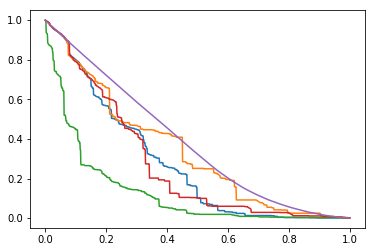

In [34]:
plt.plot(Todo[0][0][1],Todo[0][0][0])
plt.plot(Todo[0][1][1],Todo[0][1][0])
plt.plot(Todo[0][2][1],Todo[0][2][0])
plt.plot(Todo[0][3][1],Todo[0][3][0])
plt.plot(Todo[0][3][1],Todo[0][4][0])
plt.show()

In [2]:
#LECTURA Para trabajar con los archivos txt de la carpeta DemoliendoRedes          
def leetxt(NombreArchivo):    ##Le ponés entre comillas y .txt el nombre del archivo y lo lee
    lectura1=[]               ##la función devuelve dos listas. la primera es la lista1 de arriba, la segunda la lista2
    lectura2=[]               ##Para aplicarla es poner f=leetxt("NombreArchivo.txt")
    with open(NombreArchivo, 'r') as f: ## f[0] va a ser lista1
        contenido= f.readlines()        ## f[1] va a ser lista2
        for x in contenido:             ## Al igual que la de arriba se puede extender fácil a más de dos listas
            row = x.split()
            lectura1.append(float(row[0]))
            lectura2.append(float(row[1]))
    return lectura1, lectura2

In [13]:
TodoG=[]
for j in Centralidades:
    TodoG.append(leetxt("DemoliendoRedes/G_{}.txt".format(j)))

TodoG1=[]
for j in Centralidades:
    TodoG1.append(leetxt("DemoliendoRedes/G1_{}.txt".format(j)))
TodoG2=[]
for j in Centralidades:
    TodoG2.append(leetxt("DemoliendoRedes/G2_{}.txt".format(j)))

TodoG3=[]
for j in Centralidades[:4]:
    TodoG3.append(leetxt("DemoliendoRedes/G3_{}.txt".format(j)))


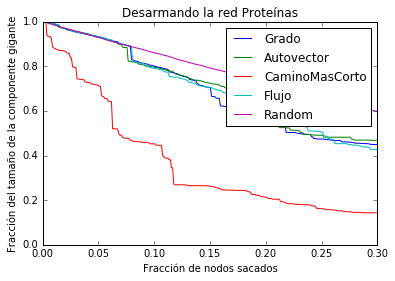

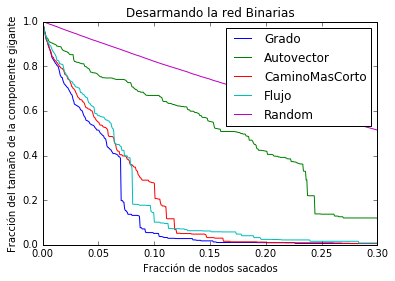

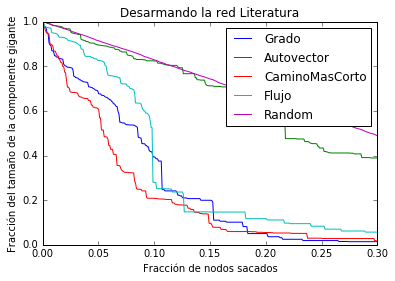

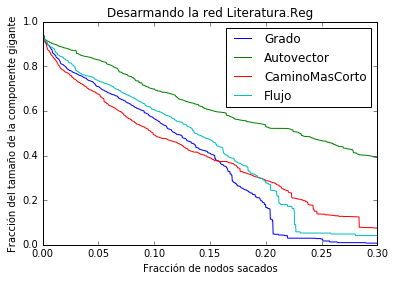

In [16]:
plt.xlim(xmax=0.3)
plt.plot(TodoG[0][1],TodoG[0][0],label="Grado")
plt.plot(TodoG[1][1],TodoG[1][0], label="Autovector")
plt.plot(TodoG[2][1],TodoG[2][0], label="CaminoMasCorto")
plt.plot(TodoG[3][1],TodoG[3][0], label="Flujo")
plt.plot(TodoG[4][1],TodoG[4][0], label="Random")
plt.legend()
plt.title("Desarmando la red Proteínas")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

plt.xlim(xmax=0.3)
plt.plot(TodoG1[0][1],TodoG1[0][0],label="Grado")
plt.plot(TodoG1[1][1],TodoG1[1][0], label="Autovector")
plt.plot(TodoG1[2][1],TodoG1[2][0], label="CaminoMasCorto")
plt.plot(TodoG1[3][1],TodoG1[3][0], label="Flujo")
plt.plot(TodoG1[4][1],TodoG1[4][0], label="Random")
plt.legend()
plt.title("Desarmando la red Binarias")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

plt.xlim(xmax=0.3)
plt.plot(TodoG2[0][1],TodoG2[0][0],label="Grado")
plt.plot(TodoG2[1][1],TodoG2[1][0], label="Autovector")
plt.plot(TodoG2[2][1],TodoG2[2][0], label="CaminoMasCorto")
plt.plot(TodoG2[3][1],TodoG2[3][0], label="Flujo")
plt.plot(TodoG2[4][1],TodoG2[4][0], label="Random")
plt.legend()
plt.title("Desarmando la red Literatura")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

plt.xlim(xmax=0.3)
plt.plot(TodoG3[0][1],TodoG3[0][0],label="Grado")
plt.plot(TodoG3[1][1],TodoG3[1][0], label="Autovector")
plt.plot(TodoG3[2][1],TodoG3[2][0], label="CaminoMasCorto")
plt.plot(TodoG3[3][1],TodoG3[3][0], label="Flujo")
# plt.plot(RandomG3[1],RandomG3[0], label="Random")
plt.legend()
plt.title("Desarmando la red Literatura.Reg")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

In [68]:
RandomG=DemoliendoRedes(G,Nnodos(G),"Random",50)
creartxt(RandomG[0],RandomG[1],"G_Random.txt")
RandomG1=DemoliendoRedes(G1,Nnodos(G1),"Random",50)
creartxt(RandomG1[0],RandomG1[1],"G1_Random.txt")

RandomG2=DemoliendoRedes(G2,Nnodos(G2),"Random",50)
creartxt(RandomG2[0],RandomG2[1],"G2_Random.txt")



In [69]:
# Nunca corrió
RandomG3=DemoliendoRedes(G3,Nnodos(G3),"Random",50)
creartxt(RandomG3[0],RandomG3[1],"G3_Random.txt")

KeyboardInterrupt: 

NameError: name 'RandomG3' is not defined

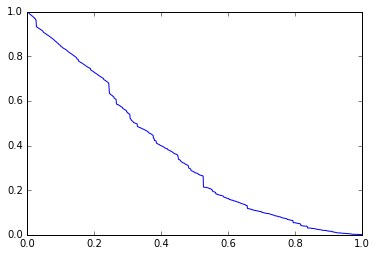

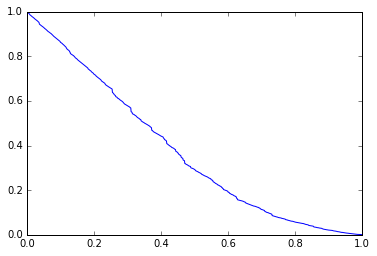